# Hyperparameter Searching

## Setup Phase

In [1]:
# pip install libraries


!pip install datasets -Uqq
!pip install transformers[sentencepiece] -Uqq
!pip install -qq wandb --upgrade

In [1]:
# Setting up the cache
import os
caches_dir = ["Y:/.cache/", "F:/.cache/", "E:/.cache/"]

# Will set the cache in the first caches dir found in the storage
for cache in caches_dir:
    if os.path.exists(cache):
        os.environ['HF_HOME'] = cache
        print(f"Cache path set on {cache}")
        break
    else:
        print(f"Path does not  exist {cache}")

Cache path set on Y:/.cache/


In [2]:
import wandb
wandb.login()


%env WANDB_PROJECT=vit_snacks_sweeps
%env WANDB_LOG_MODEL=true

wandb: Currently logged in as: rkillerfrost (alyz). Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=vit_snacks_sweeps
env: WANDB_LOG_MODEL=true


## Dataset

In [3]:
from datasets import load_dataset


datasets = load_dataset('Matthijs/snacks')
labels = datasets['train'].features['label']


In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

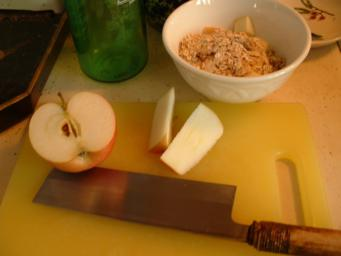

In [5]:
datasets['validation'][0]['image']

## Model

In [6]:
from transformers import ViTFeatureExtractor


checkpoint = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)

E:\venv\ml\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Data Augmentation

In [12]:
# data augmentation transformations
import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    ToTensor,
    ToPILImage
)

if "height" in feature_extractor.size:
    size = (feature_extractor.size["height"], feature_extractor.size["width"])
    crop_size = size
    max_size = None

# train
train_aug_transforms = Compose([
    RandomResizedCrop(size=size),
    RandomHorizontalFlip(p=0.5),
    RandomAdjustSharpness(sharpness_factor=5, p=0.5),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])


# validation/test
valid_aug_transforms = Compose([
    Resize(size=(feature_extractor.size, feature_extractor.size)),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [13]:
# Data Transformations (on-the-fly)
def apply_train_aug_transforms(examples):
  examples['pixel_values'] = [train_aug_transforms(img.convert('RGB')) for img in examples['image']]
  return examples


def apply_valid_aug_transforms(examples):
  examples['pixel_values'] = [valid_aug_transforms(img.convert('RGB')) for img in examples['image']]
  return examples


datasets['train'].set_transform(apply_train_aug_transforms)
datasets['validation'].set_transform(apply_valid_aug_transforms)
datasets['test'].set_transform(apply_valid_aug_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


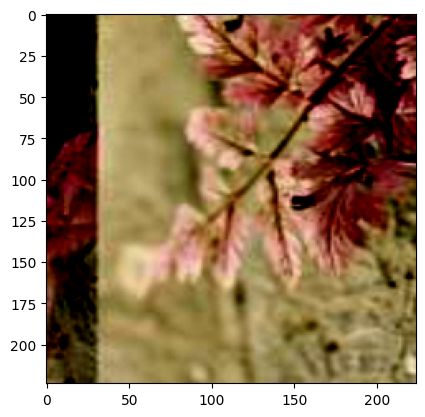

In [15]:
def run_test(arr: torch.Tensor) -> None:
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    
    arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
    plt.imshow(arr_)
    plt.show()
run_test(datasets['train'][0]['pixel_values'].T)

In [16]:
datasets_processed = datasets.rename_column('label', 'labels') # for id2labels & labels2id

In [17]:
from transformers import ViTForImageClassification

def model_init():
    vit_model = ViTForImageClassification.from_pretrained(
        checkpoint,
        num_labels=labels.num_classes,
        id2label={index: label for index, label in enumerate(labels.names)},
        label2id={label: index for index, label in enumerate(labels.names)}
    )
    return vit_model

## Hyperparameter Search Setup

In [18]:
# method
sweep_config = {
    'method': 'random'
}


# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 1
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}

sweep_config['parameters'] = parameters_dict

In [19]:
sweep_config

{'method': 'random',
 'parameters': {'epochs': {'value': 1},
  'batch_size': {'values': [8, 16, 32, 64]},
  'learning_rate': {'distribution': 'log_uniform_values',
   'min': 1e-05,
   'max': 0.001},
  'weight_decay': {'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}}}

In [20]:
sweep_id = wandb.sweep(sweep_config, project='vit-snacks-sweeps')

Create sweep with ID: ygj6tfqa
Sweep URL: https://wandb.ai/alyz/vit-snacks-sweeps/sweeps/ygj6tfqa


##  Trainer Functions

In [21]:
# define function to compute metrics
from datasets import load_metric
import numpy as np


def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')


  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))


  return metrics

In [22]:
def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['labels'] for example in examples])
  return {'pixel_values': pixel_values, 'labels': labels}

In [23]:
from transformers import TrainingArguments, Trainer


def train(config=None):
  with wandb.init(config=config):
    # set sweep configuration
    config = wandb.config


    # set training arguments
    training_args = TrainingArguments(
        output_dir='vit-sweeps',
    	report_to='wandb',  # Turn on Weights & Biases logging
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
        fp16=True
    )


    # define training loop
    trainer = Trainer(
        # model,
        model_init=model_init,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=datasets_processed['train'],
        eval_dataset=datasets_processed['validation'],
        compute_metrics=compute_metrics_fn
    )


    # start training loop
    trainer.train()

In [ ]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: fzy7lks1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0004961942635220934
wandb: 	weight_decay: 0.5


E:\venv\ml\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting t

Epoch,Training Loss,Validation Loss
